# Notebook Setup

In [1]:
from __future__ import print_function
from google.colab import auth
from google.cloud import bigquery
from google.cloud.bigquery import magics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [2]:
auth.authenticate_user()

In [3]:
#@title Fill out this form then press [shift ⇧]+[enter ⏎] {run: "auto"}
import subprocess
import re

analysis_project = 'mimic-iv-2022bv8'  #@param {type:"string"}

admissions_table = 'physionet-data.mimic_core.admissions'  # @param {type: "string"}
d_icd_diagnoses_table = 'physionet-data.mimic_hosp.d_icd_diagnoses'  # @param {type: "string"}
diagnoses_icd_table = 'physionet-data.mimic_hosp.diagnoses_icd'  # @param {type: "string"}
patients_table = 'physionet-data.mimic_core.patients'  # @param {type: "string"}
labevents_table = 'physionet-data.mimic_hosp.labevents'  # @param {type: "string"}
d_labitems = 'physionet-data.mimic_hosp.d_labitems'  # @param {type: "string"}

# Preprocess queries made with the %%bigquery magic
# by substituting these values
sub_dict = {
    'analysis_project': analysis_project,
    'admissions_table': admissions_table,
    'd_icd_diagnoses_table': d_icd_diagnoses_table,
    'diagnoses_icd_table': diagnoses_icd_table,
    'patients_table': patients_table,
    'labevents_table': labevents_table,
    'd_labitems': d_labitems,
    'ml_table_prefix': analysis_project + '.MIMIC.models_'
}

# Set the default project for running queries
magics.context.project = analysis_project

In [4]:
# Set up the substitution preprocessing injection
original_run_query = magics._run_query
def format_and_run_query(client, query, job_config=None):
  query = query.format(**sub_dict)
  #return original_run_query(client, query, job_config)
  return original_run_query(client, query, job_config)

#bigquery.magics._run_query = format_and_run_query
magics._run_query = format_and_run_query

print('analysis_project:', analysis_project)
print()
print('custom %%bigquery magic substitutions:')
for k, v in sub_dict.items():
  print(' ', '{%s}' % k, '→', v)

analysis_project: mimic-iv-2022bv8

custom %%bigquery magic substitutions:
  {analysis_project} → mimic-iv-2022bv8
  {admissions_table} → physionet-data.mimic_core.admissions
  {d_icd_diagnoses_table} → physionet-data.mimic_hosp.d_icd_diagnoses
  {diagnoses_icd_table} → physionet-data.mimic_hosp.diagnoses_icd
  {patients_table} → physionet-data.mimic_core.patients
  {labevents_table} → physionet-data.mimic_hosp.labevents
  {d_labitems} → physionet-data.mimic_hosp.d_labitems
  {ml_table_prefix} → mimic-iv-2022bv8.MIMIC.models_


In [5]:
%config InlineBackend.figure_format = 'svg'

In [6]:
bq = bigquery.Client(project=analysis_project)

In [7]:
if 'MIMIC' not in [d.dataset_id for d in list(bq.list_datasets())]:
  dataset_id = "{}.MIMIC".format(bq.project)
  # Construct a full Dataset object to send to the API.
  # Send the dataset to the API for creation.
  # Raises google.api_core.exceptions.Conflict if the Dataset already
  # exists within the project.

  dataset = bigquery.Dataset(dataset_id)
  dataset = bq.create_dataset(dataset)  # Make an API request.

# Evaluation Functions

In [8]:
def set_precision(df):
  df['precision'] = df.true_positives / (df.true_positives + df.false_positives)

def set_true_positive_rate(df):
  df['true_positive_rate'] = df.true_positives / (df.true_positives + df.false_negatives)

def plot_roc_curve(df, label=None):
  # manually add the threshold = -∞ point
  df = df[df.true_positives != 0]
  tpr = [0] + list(df.true_positive_rate)
  fpr = [0] + list(df.false_positive_rate)
  # x=fpr, y=tpr line chart
  plt.plot(fpr, tpr, label=label)

def plot_precision_recall(df, label=None):
  # manually add the threshold = -∞ point
  df = df[df.true_positives != 0]
  recall = [0] + list(df.recall)
  precision = [1] + list(df['precision'])

  # x=recall, y=precision line chart
  plt.plot(recall, precision, label=label)

# Models

### Explore the number of laboratories

In [9]:
%%bigquery hist_df
SELECT
  n_labs, COUNT(*) AS cnt
FROM (
  SELECT
    COUNT(*) AS n_labs
  FROM
    `{labevents_table}`
  WHERE HADM_ID IS NOT NULL 
  GROUP BY
    HADM_ID
)
GROUP BY n_labs
ORDER BY n_labs

(array([   0,    1,    2, ..., 3295, 3296, 3297]),
 <a list of 34 Text major ticklabel objects>)

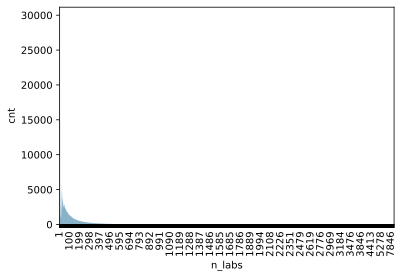

In [10]:
g = sns.barplot(
    x=hist_df.n_labs, y=hist_df.cnt, color=sns.color_palette()[0])
# Remove every fifth label on the x-axis for readability
for i, label in enumerate(g.get_xticklabels()):
  if i % 99 != 0 and i != 0:
    label.set_visible(False)
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Bar plot of number of labs per addmission')

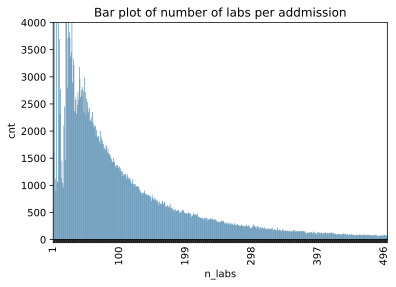

In [11]:
# zoom in 
g = sns.barplot(
    x=hist_df.n_labs, y=hist_df.cnt, color=sns.color_palette()[0])
g.set_xlim(0, 500)
g.set_ylim(0, 4000)
# Remove every fifth label on the x-axis for readability
for i, label in enumerate(g.get_xticklabels()):
  if i % 99 != 0 and i != 0:
    label.set_visible(False)
plt.xticks(rotation=90)
plt.title('Bar plot of number of labs per addmission')

### 1. Predict mortality during admission by number of labs

In [12]:
%%bigquery
# BigQuery ML create model statement:
CREATE OR REPLACE MODEL `{ml_table_prefix}complexity_mortality_models`

OPTIONS(
  # Use logistic_reg for discrete predictions (classification)
  model_type = 'logistic_reg',
  # (𝜎 = 0.5 ⇒ 𝜆 = 2)
  l2_reg = 2,
  # Identify the column to use as the label (dependent variable)
  input_label_cols = ["died"]
)
AS
# standard SQL query to train the model with:
SELECT
  COUNT(*) AS number_of_labs,
  MAX(HOSPITAL_EXPIRE_FLAG) as died
FROM
  `{admissions_table}`
  INNER JOIN `{labevents_table}`
  USING (HADM_ID)
GROUP BY HADM_ID

""


In [13]:
%%bigquery comp_roc
SELECT * FROM ML.ROC_CURVE(MODEL `{ml_table_prefix}complexity_mortality_models`)

In [14]:
%%bigquery eval_auc
SELECT * FROM ML.EVALUATE(MODEL `{ml_table_prefix}complexity_mortality_models`)

Precision Recall curve and AUC on the evaluation set

Text(0, 0.5, 'Precision $\\left(\\frac{T_p}{T_p + F_p} \\right)$')

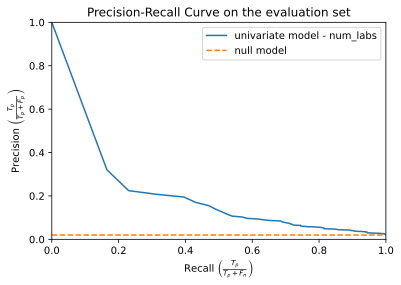

In [15]:
set_precision(comp_roc)

plot_precision_recall(comp_roc, label='univariate model - num_labs')

plt.plot(
    np.linspace(0, 1, 2), [comp_roc.precision.iloc[-1]] * 2,
    label='null model',
    linestyle='--')
plt.title('Precision-Recall Curve on the evaluation set')

plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'Recall $\left(\frac{T_p}{T_p + F_n} \right)$')
plt.ylabel(r'Precision $\left(\frac{T_p}{T_p + F_p} \right)$')

In [16]:
print('AUC of precision recall curve is:')
auc(comp_roc.recall, comp_roc.precision)

AUC of precision recall curve is:


0.12956912414540442

ROC curve and AUC on the evaluation set

Text(0, 0.5, 'TP Rate')

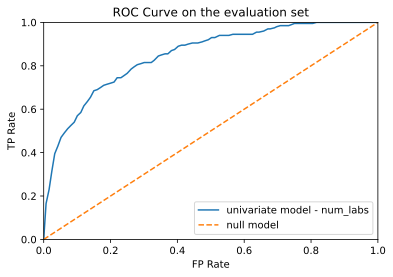

In [17]:
set_true_positive_rate(comp_roc)

plot_roc_curve(comp_roc, label='univariate model - num_labs')
plt.plot(
    np.linspace(0, 1, 10), np.linspace(0, 1, 10),
    label='null model',
    linestyle='--')
plt.title('ROC Curve on the evaluation set')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'FP Rate')
plt.ylabel(r'TP Rate')

In [18]:
print('AUC of ROC curve is:')
eval_auc['roc_auc']

AUC of ROC curve is:


0    0.847382
Name: roc_auc, dtype: float64

### 2. Predict mortality during admission by number of labs, gender, age, admission type, admission location, insurance, marital status, and ethnicity.

In [19]:
%%bigquery
# BigQuery ML create model statement:
CREATE OR REPLACE MODEL `{ml_table_prefix}mortality_by_all_features`

OPTIONS(
  # Use logistic_reg for discrete predictions (classification) 
  model_type = 'logistic_reg',
  # (𝜎 = 0.5 ⇒ 𝜆 = 2)
  l1_reg = 2,
  # Identify the column to use as the label (dependent variable)
  input_label_cols = ["died"]
)
AS

WITH labs AS (
  SELECT 
    HADM_ID,
    COUNT(*) AS n_labs,
  FROM
    `{labevents_table}`
  GROUP BY HADM_ID
)

SELECT
  labs.n_labs,
  patients.gender,
  patients.anchor_age,
  adm.admission_type,
  adm.admission_location,
  adm.insurance,
  adm.marital_status,
  adm.ethnicity,
  adm.HOSPITAL_EXPIRE_FLAG as died,

FROM 
  `{admissions_table}` AS adm
  LEFT JOIN `{patients_table}` AS patients USING (SUBJECT_ID)
  LEFT JOIN labs USING (HADM_ID)

""


In [20]:
%%bigquery comp_roc_2
SELECT * FROM ML.ROC_CURVE(MODEL `{ml_table_prefix}mortality_by_all_features`)

In [21]:
%%bigquery eval_auc_2
SELECT * FROM ML.EVALUATE(MODEL `{ml_table_prefix}mortality_by_all_features`)

Precision Recall curve and AUC on the evaluation set

Text(0, 0.5, 'Precision $\\left(\\frac{T_p}{T_p + F_p} \\right)$')

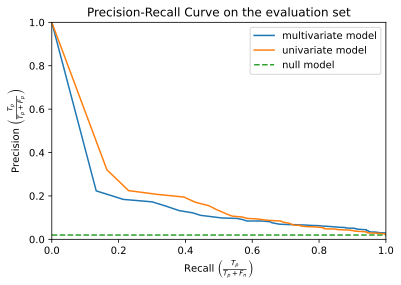

In [22]:
set_precision(comp_roc_2)

plot_precision_recall(comp_roc_2,  label='multivariate model')
plot_precision_recall(comp_roc,  label='univariate model')

plt.plot(
    np.linspace(0, 1, 2), [comp_roc.precision.iloc[-1]] * 2,
    label='null model',
    linestyle='--')
plt.title('Precision-Recall Curve on the evaluation set')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'Recall $\left(\frac{T_p}{T_p + F_n} \right)$')
plt.ylabel(r'Precision $\left(\frac{T_p}{T_p + F_p} \right)$')

In [23]:
print('AUC of precision recall curve is:')
auc(comp_roc_2.recall, comp_roc_2.precision)

AUC of precision recall curve is:


0.10615998401693173

ROC curve and AUC on the evaluation set

Text(0, 0.5, 'TP Rate')

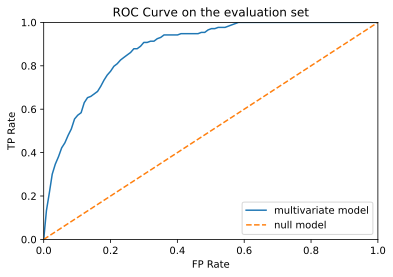

In [24]:
set_true_positive_rate(comp_roc_2)

plot_roc_curve(comp_roc_2, label='multivariate model')
plt.plot(
    np.linspace(0, 1, 10), np.linspace(0, 1, 10),
    label='null model',
    linestyle='--')
plt.title('ROC Curve on the evaluation set')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'FP Rate')
plt.ylabel(r'TP Rate')

In [25]:
print('AUC of ROC curve is:')
eval_auc_2["roc_auc"]

AUC of ROC curve is:


0    0.876195
Name: roc_auc, dtype: float64

### 3. Predict mortality during admission by number of labs, gender, age, admission type, admission location, insurance, marital status, ethnicity and one hot encoding for 𝑚 most common labs. Where 𝑚 ∈ {8,16,32,64,128,256,512}.

In [26]:
%%bigquery top_labs
WITH top_lab AS (
  SELECT COUNT(*) AS count, itemid FROM `{labevents_table}`
  GROUP BY itemid
)
SELECT top_lab.itemid, top_lab.count FROM top_lab 
ORDER BY count DESC LIMIT 1024

In [27]:
top_n_labs = (8, 16, 32, 64, 128, ) # 256, 512)

In [28]:
query_jobs = list()
for m in top_n_labs:
  # The expressions for creating the new columns for each input diagnosis
  lab_columns = list()
  for _, row in top_labs.iloc[:m].iterrows():
    lab_columns.append('MAX(IF(itemid = {0}, 1.0, 0.0))'
                             ' as `itemid_{0}`'.format(row.itemid))

  query = """
  CREATE OR REPLACE MODEL `{ml_table_prefix}predict_mortality_labs_{m}`
  OPTIONS(model_type = 'logistic_reg', l1_reg = 2, input_label_cols = ["died"])
  AS
  WITH labs AS (
    SELECT 
      HADM_ID,
      COUNT(*) AS n_labs,
      {lab_cols}
    FROM `{labevents_table}`
    WHERE itemid IS NOT NULL
    GROUP BY HADM_ID
  )

  SELECT
    labs.*,
    patients.gender,
    patients.anchor_age,
    adm.admission_type,
    adm.admission_location,
    adm.insurance,
    adm.marital_status,
    adm.ethnicity,
    adm.HOSPITAL_EXPIRE_FLAG as died,

  FROM 
    `{admissions_table}` AS adm
    LEFT JOIN `{patients_table}` AS patients USING (SUBJECT_ID)
    LEFT JOIN labs USING (HADM_ID)
  """.format(
      m=m, lab_cols=',\n    '.join(lab_columns), **sub_dict)
  # Run the query, and track its progress with query_jobs
  query_jobs.append(bq.query(query))

# Wait for all of the models to finish training
for j in query_jobs:
  j.exception()

In [29]:
eval_queries = list()
for m in top_n_labs:
  eval_queries.append(
      'SELECT * FROM ML.EVALUATE('
      'MODEL `{ml_table_prefix}predict_mortality_labs_{}`)'
      .format(m, **sub_dict))
eval_query = '\nUNION ALL\n'.join(eval_queries)
results = bq.query(eval_query).result().to_dataframe()
results

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.428571,0.017964,0.982890,0.034483,0.068349,0.883956
1,0.400000,0.022472,0.982077,0.042553,0.074774,0.843627
2,0.500000,0.028090,0.982184,0.053191,0.070878,0.871185
3,1.000000,0.005155,0.980714,0.010256,0.072201,0.914252
4,0.000000,0.000000,0.981619,0.000000,0.064304,0.921091


Precision Recall curve and AUC on the evaluation set

Precision Recall AUC of 8 labs is: 0.12559399324267298
Precision Recall AUC of 16 labs is: 0.15423757115963105
Precision Recall AUC of 32 labs is: 0.20254042096449942
Precision Recall AUC of 64 labs is: 0.23520750212613972
Precision Recall AUC of 128 labs is: 0.37980425901605486


Text(0, 0.5, 'Precision $\\left(\\frac{T_p}{T_p + F_p} \\right)$')

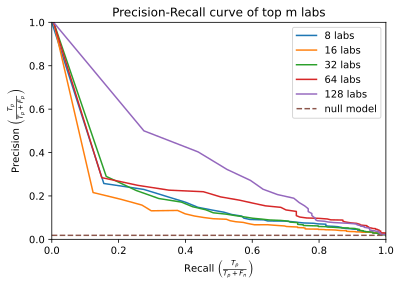

In [30]:
for m in top_n_labs:
  df = bq.query('SELECT * FROM ML.ROC_CURVE('
                'MODEL `{ml_table_prefix}predict_mortality_labs_{}`)'
                .format(m, **sub_dict)).result().to_dataframe()
  set_precision(df)
  plot_precision_recall(df, label='{} labs'.format(m))
  roc_auc = auc(df.recall, df.precision)
  print(f'Precision Recall AUC of {m} labs is: {roc_auc}')


plt.plot(
    np.linspace(0, 1, 2), [df.precision.iloc[-1]] * 2,
    label='null model',
    linestyle='--')
plt.title('Precision-Recall curve of top m labs')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'Recall $\left(\frac{T_p}{T_p + F_n} \right)$')
plt.ylabel(r'Precision $\left(\frac{T_p}{T_p + F_p} \right)$')

ROC curve and AUC on the evaluation set

ROC AUC of 8 labs is: 0.883956043956044
ROC AUC of 16 labs is: 0.8436273726273726
ROC AUC of 32 labs is: 0.8711848151848152
ROC AUC of 64 labs is: 0.9142517482517483
ROC AUC of 128 labs is: 0.9210909090909091


Text(0, 0.5, 'TP Rate')

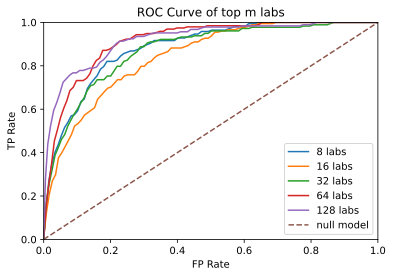

In [31]:
for i, m in enumerate(top_n_labs):
  roc_auc = results.iloc[i]['roc_auc']
  df = bq.query('SELECT * FROM ML.ROC_CURVE('
                'MODEL `{ml_table_prefix}predict_mortality_labs_{}`)'
                .format(m, **sub_dict)).result().to_dataframe()
  set_true_positive_rate(df)
  plot_roc_curve(df, label='{} labs'.format(m))
  print(f'ROC AUC of {m} labs is: {roc_auc}')

plt.plot(
    np.linspace(0, 1, 10), np.linspace(0, 1, 10),
    label='null model',
    linestyle='--')
plt.title('ROC Curve of top m labs')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'FP Rate')
plt.ylabel(r'TP Rate')

### 4. Choose the optimal 𝑚 and add to that model the most common 256 diagnoses (transformed to one hot encoding).

In [32]:
%%bigquery top_diagnoses
WITH top_diag AS (
  SELECT COUNT(*) AS count, icd_code, icd_version FROM `{diagnoses_icd_table}`
  GROUP BY icd_code, icd_version
)
SELECT top_diag.icd_code, top_diag.icd_version, icd_lookup.long_title, top_diag.count FROM
top_diag JOIN
 `{d_icd_diagnoses_table}` AS icd_lookup
USING (icd_code,	icd_version)
ORDER BY count DESC LIMIT 1024

In [33]:
# The expressions for creating the new columns for each input diagnosis
diagnosis_columns = list()
for _, row in top_diagnoses.iloc[:64].iterrows():
  diagnosis_columns.append('MAX(IF(icd_code = "{0}", 1.0, 0.0))'
                            ' as `icd9_{0}`'.format(row.icd_code))

In [34]:
lab_columns = list()
for _, row in top_labs.iloc[:64].iterrows():
  lab_columns.append('MAX(IF(itemid = {0}, 1.0, 0.0))'
                            ' as `itemid_{0}`'.format(row.itemid))

In [35]:
query_jobs_new = list()
query = """ 
CREATE OR REPLACE MODEL `{ml_table_prefix}predict_mortality_labs_and_diagnoses`
OPTIONS(model_type = 'logistic_reg', l1_reg = 2, input_label_cols = ["died"])
AS
WITH labs AS (
  SELECT 
    HADM_ID,
    COUNT(*) AS n_labs,
    {lab_cols}
  FROM `{labevents_table}`
  WHERE itemid IS NOT NULL
  GROUP BY HADM_ID
),
diagnoses AS (
  SELECT
    HADM_ID,
    COUNT(*) AS num_diag,
    {diag_cols}
  FROM `{diagnoses_icd_table}`
  WHERE icd_code IS NOT NULL
  GROUP BY HADM_ID
)

SELECT
  labs.* EXCEPT (HADM_ID),
  patients.gender,
  patients.anchor_age,
  adm.admission_type,
  adm.admission_location,
  adm.insurance,
  adm.marital_status,
  adm.ethnicity,
  adm.HOSPITAL_EXPIRE_FLAG as died,
  diagnoses.* EXCEPT(HADM_ID)

FROM 
  `{admissions_table}` AS adm
  LEFT JOIN `{patients_table}` AS patients USING (SUBJECT_ID)
  LEFT JOIN labs USING (HADM_ID)
  LEFT JOIN diagnoses USING (HADM_ID)
""".format(
    diag_cols=',\n    '.join(diagnosis_columns), lab_cols=',\n    '.join(lab_columns), **sub_dict)
# Run the query, and track its progress with query_jobs
query_jobs_new.append(bq.query(query))

# Wait for all of the models to finish training
for j in query_jobs_new:
  j.exception()

In [36]:
%%bigquery comp_roc_3
SELECT * FROM ML.ROC_CURVE(MODEL `{ml_table_prefix}predict_mortality_labs_and_diagnoses`)

In [37]:
%%bigquery eval_auc_3
SELECT * FROM ML.EVALUATE(MODEL `{ml_table_prefix}predict_mortality_labs_and_diagnoses`)

Precision Recall curve and AUC on the evaluation set

Text(0, 0.5, 'Precision $\\left(\\frac{T_p}{T_p + F_p} \\right)$')

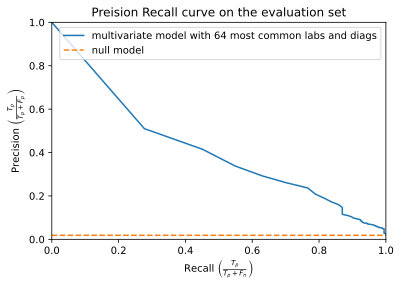

In [38]:
set_precision(comp_roc_3)

plot_precision_recall(comp_roc_3, label='multivariate model with 64 most common labs and diags')
plt.plot(
    np.linspace(0, 1, 2), [comp_roc_3.precision.iloc[-1]] * 2,
    label='null model',
    linestyle='--')
plt.title('Preision Recall curve on the evaluation set')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'Recall $\left(\frac{T_p}{T_p + F_n} \right)$')
plt.ylabel(r'Precision $\left(\frac{T_p}{T_p + F_p} \right)$')

In [39]:
print('AUC of precision recall curve is:')
auc(comp_roc_3.recall, comp_roc_3.precision)

AUC of precision recall curve is:


0.27927802139598346

ROC curve and AUC on the evaluation set

Text(0, 0.5, 'TP Rate')

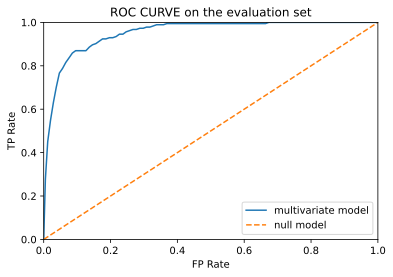

In [40]:
set_true_positive_rate(comp_roc_3)

plot_roc_curve(comp_roc_3, label='multivariate model')
plt.plot(
    np.linspace(0, 1, 10), np.linspace(0, 1, 10),
    label='null model',
    linestyle='--')
plt.title('ROC CURVE on the evaluation set')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'FP Rate')
plt.ylabel(r'TP Rate')

In [41]:
print('AUC of ROC curve is:')
eval_auc_3["roc_auc"]

AUC of ROC curve is:


0    0.951899
Name: roc_auc, dtype: float64

### 5. Bonus: (10 points): Same features as previous one, but limit the data that was collected in the first 24 hours of admission.

The difference here is that I filter the labs by the following condition statement:
 
 WHERE 
    DATE_DIFF(labev.charttime, adm.admittime, hour) <= 24 
  AND 
    DATE_DIFF(labev.charttime, adm.admittime, hour) >= 0 

I used the admission time field from the admission table and compared the time with the time when the lab was taken.  

In [50]:
query_jobs_new = list()
query = """ 
CREATE OR REPLACE MODEL `{ml_table_prefix}predict_mortality_labs_and_diagnoses_limit_by_date`
OPTIONS(model_type = 'logistic_reg', l1_reg = 2, input_label_cols = ["died"])
AS
WITH labs AS (
  SELECT 
    HADM_ID,
    COUNT(*) AS n_labs,
    {lab_cols}
  FROM `{labevents_table}` AS labev LEFT JOIN `{admissions_table}` as adm USING(HADM_ID)
  WHERE 
    DATE_DIFF(labev.charttime, adm.admittime, hour) <= 24 
  AND 
    DATE_DIFF(labev.charttime, adm.admittime, hour) >= 0 
  AND 
    itemid is not NULL
  GROUP BY HADM_ID
),
diagnoses AS (
  SELECT
    HADM_ID,
    COUNT(*) AS num_diag,
    {diag_cols}
  FROM `{diagnoses_icd_table}`
  WHERE icd_code IS NOT NULL
  GROUP BY HADM_ID
)

SELECT
  labs.* EXCEPT (HADM_ID),
  patients.gender,
  patients.anchor_age,
  adm.admission_type,
  adm.admission_location,
  adm.insurance,
  adm.marital_status,
  adm.ethnicity,
  adm.HOSPITAL_EXPIRE_FLAG as died,
  diagnoses.* EXCEPT(HADM_ID)

FROM 
  `{admissions_table}` AS adm
  LEFT JOIN `{patients_table}` AS patients USING (SUBJECT_ID)
  LEFT JOIN labs USING (HADM_ID)
  LEFT JOIN diagnoses USING (HADM_ID)
""".format(
    diag_cols=',\n    '.join(diagnosis_columns), lab_cols=',\n    '.join(lab_columns), **sub_dict)
# Run the query, and track its progress with query_jobs
query_jobs_new.append(bq.query(query))

# Wait for all of the models to finish training
for j in query_jobs_new:
  j.exception()

In [9]:
%%bigquery comp_roc_4
SELECT * FROM ML.ROC_CURVE(MODEL `{ml_table_prefix}predict_mortality_labs_and_diagnoses_limit_by_date`)

In [10]:
%%bigquery eval_auc_4
SELECT * FROM ML.EVALUATE(MODEL `{ml_table_prefix}predict_mortality_labs_and_diagnoses_limit_by_date`)

Precision Recall curve and AUC on the evaluation set

Text(0, 0.5, 'Precision $\\left(\\frac{T_p}{T_p + F_p} \\right)$')

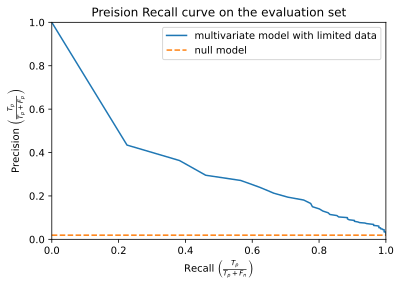

In [12]:
set_precision(comp_roc_4)

plot_precision_recall(comp_roc_4, label='multivariate model with limited data')
plt.plot(
    np.linspace(0, 1, 2), [comp_roc_4.precision.iloc[-1]] * 2,
    label='null model',
    linestyle='--')
plt.title('Preision Recall curve on the evaluation set')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'Recall $\left(\frac{T_p}{T_p + F_n} \right)$')
plt.ylabel(r'Precision $\left(\frac{T_p}{T_p + F_p} \right)$')

In [13]:
print('AUC of precision recall curve is:')
auc(comp_roc_4.recall, comp_roc_4.precision)

AUC of precision recall curve is:


0.23379177062054202

ROC curve and AUC on the evaluation set

Text(0, 0.5, 'TP Rate')

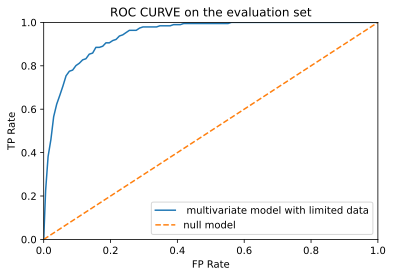

In [14]:
set_true_positive_rate(comp_roc_4)

plot_roc_curve(comp_roc_4, label=' multivariate model with limited data')
plt.plot(
    np.linspace(0, 1, 10), np.linspace(0, 1, 10),
    label='null model',
    linestyle='--')
plt.title('ROC CURVE on the evaluation set')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'FP Rate')
plt.ylabel(r'TP Rate')

In [15]:
print('AUC of ROC curve is:')
eval_auc_4["roc_auc"]

AUC of ROC curve is:


0    0.940492
Name: roc_auc, dtype: float64

# Discussion

I created 5 different models in order to predict mortality during admissions. The difference between the models were the features that I used - I started with the number of labs only, i.e counted for each hadm_id the number of lab events it has and predicted mortality using this feature only. The results show that the ROC AUC is 0.847 and the precison-recall AUC is 0.13, so I guess that there is a relationship between the number of labs the patient had on the same admission and his probability to death. Moreover, it makes sense because if the patient is in a complex situation the hospital should use more laboratory measurements to recognize his problem. But, probably this is not the only parameter that influence the patient mortality. 
Hence, I created 4 more models:

1. The second model use the next features: number of labs, gender, age, admission type, admission location, insurance, marital status, and ethnicity (ROC AUC 0.876, Precision Recall AUC 0.106)
2. The third model use the same features but also an one hot encoding for m (8 to 128) most common labs. (optimal m = 64, ROC AUC - 0.919, Precision Recall AUC 0.17)
3. The fourth model use the same features but with the optimal m (64) that we found and also the 64 most common diagnoses. (ROC AUC - 0.952, Precision Recall AUC 0.279)
4. Same features as previous one but with data that was collected in the first 24 hours. (ROC AUC - 0.940, Precision Recall AUC - 0.234)

We can see that as we added more features, the AUC got better, but when I added too many features (e.g. 128 common labs) the model was overfitted. This is the reason why I choose m=64.

I don't think the ICU can use my model as is, because if we look at model nubmer 3 we can see that the precision and recall are very low, and these parameters are very importatant in order to predict mortality (because the data is imbalanced and have more life cases then deaths).
However, they can use the features I used but with additional features, because the results show that these features have an effect on the mortality probaility. 

